# Face Detection

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import os
import cv2
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
dataset_dir = '/content/drive/MyDrive/DATASETS/aiub_cvpr_summer_dataset'

In [44]:
IMG_SIZE = 227
BATCH_SIZE = 5

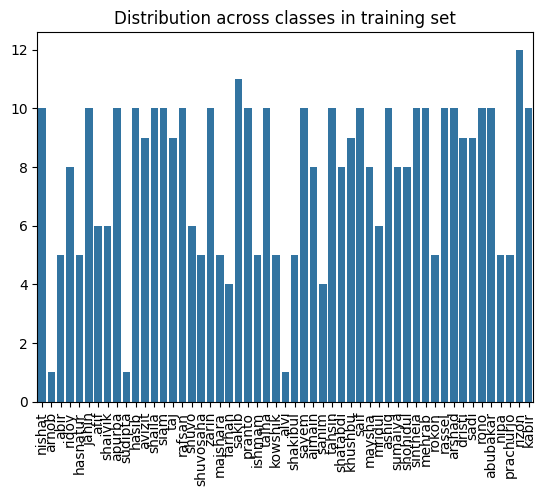

Total Train Examples = 411


In [45]:
classes = []
class_count = []
sample_no = 0

for folder in  os.listdir(dataset_dir):
    files = gb.glob(pathname= str(dataset_dir + '//' + folder + '/*.jpg')) + \
            gb.glob(pathname= str(dataset_dir + '//' + folder + '/*.jpeg')) + \
            gb.glob(pathname= str(dataset_dir + '//' + folder + '/*.png')) + \
            gb.glob(pathname= str(dataset_dir + '//' + folder + '/*.JPG')) + \
            gb.glob(pathname= str(dataset_dir + '//' + folder + '/*.JPEG'))
            # gb.glob(pathname= str(dataset_dir + '//' + folder + '/*.HEIC'))
    classes.append(folder.lower())
    class_count.append(len(files))
    sample_no += len(files)

sns.barplot(x = classes, y=class_count).set_title("Distribution across classes in training set")
plt.xticks(rotation=90)
plt.show()

print(f'Total Train Examples = {sample_no}')

In [46]:
CATEGORIES = []
for i in os.listdir(dataset_dir):
  CATEGORIES.append(i)
print(CATEGORIES)

['Nishat', 'Arnob', 'Abir', 'Ridoy', 'Hasnatur', 'Jahin', 'Afif', 'Shaivik', 'Apurba', 'Sudipta', 'Hasib', 'Avizit', 'Shaila', 'Siam', 'Taj', 'Rafsan', 'SHUVO', 'ShuvoSaha', 'Zarin', 'Maishara', 'Farhan', 'Sakib', 'Pranto', 'Ishmam', 'Talha', 'Kowshik', 'Alvi', 'Shakibul', 'Sayem', 'ajmain', 'Sanim', 'Tahsin', 'Shatabdi', 'Khushbu', 'Saif', 'MAYSHA', 'MRIDUL', 'Ashiq', 'Sumaiya', 'shohidul', 'Sintheia', 'Mehrab', 'Rokon', 'Rassel', 'Arshad', 'Dristi', 'Sadi', 'Rono', 'Abubakar', 'Nipa', 'Prachurjo', 'Rizon', 'Kabir']


In [65]:
train_data = []
i = 0;
for c in CATEGORIES:
  path = os.path.join(dataset_dir, c)
  for img in os.listdir(path):
    img_arr = plt.imread(os.path.join(path,img))
    img_arr = cv2.resize(img_arr, (227,227))
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGBA2RGB)
    train_data.append([img_arr, CATEGORIES.index(c)])
    i = i +1
print(len(train_data))

412


In [67]:
for img, label in train_data:
    if img.shape != (227, 227, 3):
        print(f"Unexpected image shape: {img.shape}")
        continue  # Skip images that don't match the expected shape
    X_train.append(img)
    Y_train.append(label)


In [68]:
X_train = []
Y_train = []
i = 0
for img, label in train_data:
  X_train.append(img)
  Y_train.append(label)
X_train = (np.array(X_train)*255).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)
print(X_train.shape, Y_train.shape)

(412, 227, 227, 3) (412,)


In [74]:
from sklearn.model_selection import train_test_split

In [76]:
X_train = np.array(X_train).astype('float32')
Y_train = np.array(Y_train)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Validation set shape:", X_valid.shape, Y_valid.shape)

Training set shape: (329, 227, 227, 3) (329,)
Validation set shape: (83, 227, 227, 3) (83,)


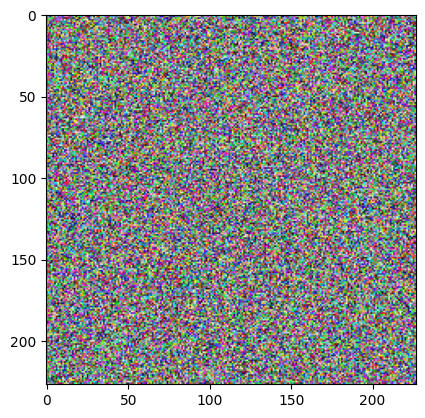

In [77]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [78]:
model = keras.Sequential([
    keras.Input(shape=X_train.shape[1:]),
    layers.Conv2D(filters=96, kernel_size=(11,11),strides=(4,4), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units=4096, activation='relu'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(units=len(CATEGORIES), activation='sigmoid')

])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 27, 27, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 13, 13, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 58,536,757 (223.30 MB)

 Trainable params: 58,517,621 (223.23 MB)

 Non-trainable params: 19,136 (74.75 KB)

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

In [84]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [85]:
h = model.fit(x=X_train, y=Y_train, epochs=10, batch_size=16, validation_data=(X_valid, Y_valid), callbacks=[early_stopping])

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.9191 - loss: 0.3592 - val_accuracy: 0.3494 - val_loss: 7.4182
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9442 - loss: 0.2185 - val_accuracy: 0.3855 - val_loss: 6.2156
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9467 - loss: 0.2403 - val_accuracy: 0.3614 - val_loss: 6.6591
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9535 - loss: 0.1503 - val_accuracy: 0.3976 - val_loss: 5.4756
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.9641 - loss: 0.2574 - val_accuracy: 0.3614 - val_loss: 5.6636
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.9416 - loss: 0.2671 - val_accuracy: 0.3614 - val_loss: 5.6130
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.9575 - loss: 0.2188 - val_accuracy: 0.3976 - val_loss: 5.7136


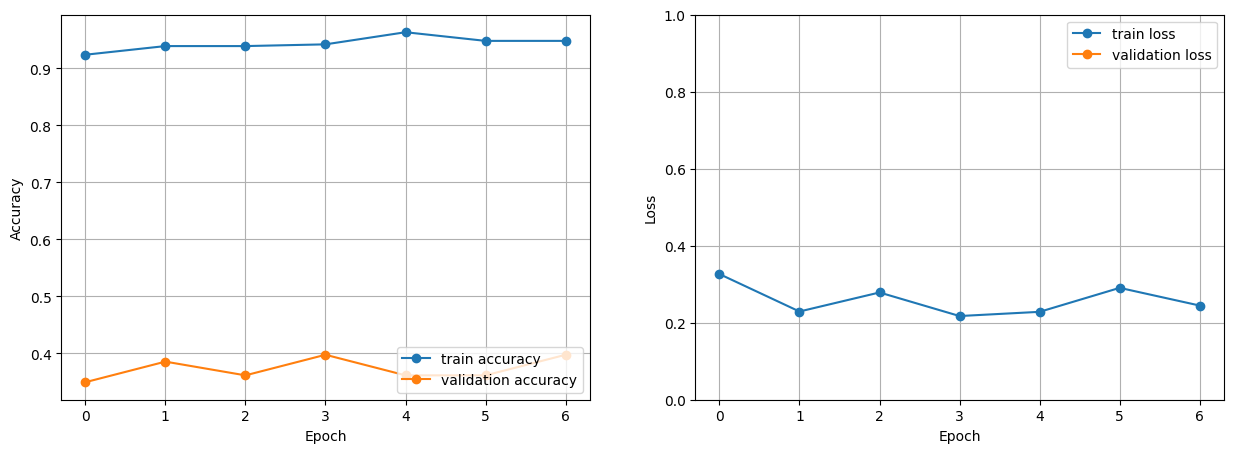

In [87]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [88]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [99]:
def process_photo(filename):

    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_classifier.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))

    for (x, y, w, h) in faces:

        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)


        crop_image = img[y:y+h, x:x+w]


        resize_img = cv2.resize(crop_image, (227, 227))
        resize_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)


        input_image = resize_img.astype('float32') / 255.0
        input_image = np.expand_dims(input_image, axis=0)

        predictions = model.predict(input_image)

        predicted_class = np.argmax(predictions, axis=1)
        label = CATEGORIES[int(predicted_class)]
        print(f'Predicted class: { label }')

        cv2.putText(img_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class: Rono


<ipython-input-99-2c3fbbb2771b>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = CATEGORIES[int(predicted_class)]


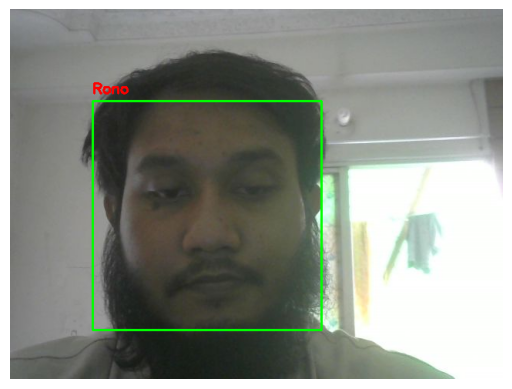

In [100]:
filename = take_photo()
process_photo(filename)

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class: Rono


<ipython-input-99-2c3fbbb2771b>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = CATEGORIES[int(predicted_class)]


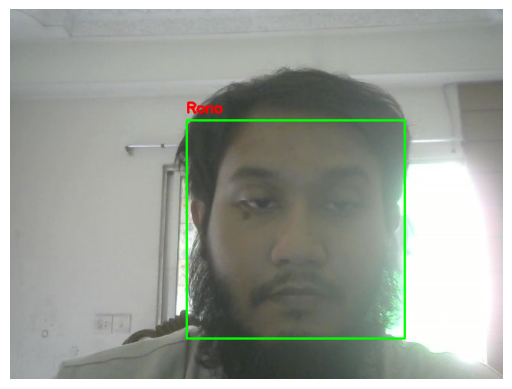

In [101]:
process_photo(take_photo())